## Setup

In [49]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [51]:
%%R 

library(tidycensus)
library(tidyverse)
library(tigris)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [52]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [53]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [54]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract",
                      state="NY",
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        oppo_sex_married="B09019_010",
                        same_sex_married="B09019_011",
                        oppo_sex_unmarried="B09019_012",
                        same_sex_unmarried="B09019_013"
                      ),
                      year = 2024,
                      survey="acs5",
                      geometry=T)

nyc_census_data

Simple feature collection with 9308 features and 5 fields (with 12 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME           variable
1  36005037600    Census Tract 376; Bronx County; New York   oppo_sex_married
2  36005037600    Census Tract 376; Bronx County; New York   same_sex_married
3  36005037600    Census Tract 376; Bronx County; New York oppo_sex_unmarried
4  36005037600    Census Tract 376; Bronx County; New York same_sex_unmarried
5  36005023502 Census Tract 235.02; Bronx County; New York   oppo_sex_married
6  36005023502 Census Tract 235.02; Bronx County; New York   same_sex_married
7  36005023502 Census Tract 235.02; Bronx County; New York oppo_sex_unmarried
8  36005023502 Census Tract 235.02; Bronx County; New York same_sex_unmarried
9  36005006400     Census Tract 64; Bronx County; N

Getting data from the 2020-2024 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [55]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 10 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 11
   GEOID       NAME                              geometry oppo_sex_married_est…¹
   <chr>       <chr>                   <MULTIPOLYGON [°]>                  <dbl>
 1 36005037600 Census Tract 37… (((-73.87038 40.87329, -…                    280
 2 36005023502 Census Tract 23… (((-73.906 40.84939, -73…                    543
 3 36005006400 Census Tract 64… (((-73.87395 40.83424, -…                    249
 4 36005039100 Census Tract 39… (((-73.89003 40.85422, -…                    670
 5 36005038000 Census Tract 38… (((-73.86627 40.87733, -…                    241
 6 36005008900 Census Tract 89… (((-73.89705 40.8168, -7…                    293
 7 36005022401 Census Tract 22… (((-73.86982 40.85548, -…                    265
 8 36005038200 Censu

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [56]:
%%R 

# your code here. refer to example notebooks for help

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ";") %>% map_chr(2) %>% str_trim(),
        same_sex_tot = same_sex_married_estimate + same_sex_unmarried_estimate,
        opposite_sex_tot = oppo_sex_married_estimate + oppo_sex_unmarried_estimate,
        total = same_sex_tot + opposite_sex_tot,
        same_sex_rate = same_sex_tot/total
    ) 

nyc_census_data

Simple feature collection with 2327 features and 15 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771


Geodetic CRS:  NAD83
# A tibble: 2,327 × 16
   GEOID       NAME                              geometry oppo_sex_married_est…¹
 * <chr>       <chr>                   <MULTIPOLYGON [°]>                  <dbl>
 1 36005037600 Census Tract 37… (((-73.87038 40.87329, -…                    280
 2 36005023502 Census Tract 23… (((-73.906 40.84939, -73…                    543
 3 36005006400 Census Tract 64… (((-73.87395 40.83424, -…                    249
 4 36005039100 Census Tract 39… (((-73.89003 40.85422, -…                    670
 5 36005038000 Census Tract 38… (((-73.86627 40.87733, -…                    241
 6 36005008900 Census Tract 89… (((-73.89705 40.8168, -7…                    293
 7 36005022401 Census Tract 22… (((-73.86982 40.85548, -…                    265
 8 36005038200 Census Tract 38… (((-73.85928 40.87773, -…                    272
 9 36005022701 Census Tract 22… (((-73.91408 40.84528, -…                    279
10 36005019500 Census Tract 19… (((-73.92426 40.83068, -…        

In [57]:
%%R

nyc_census_data <- nyc_census_data %>%
  erase_water()

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 97 rows containing non-finite outside the scale range (`stat_bin()`). 
  


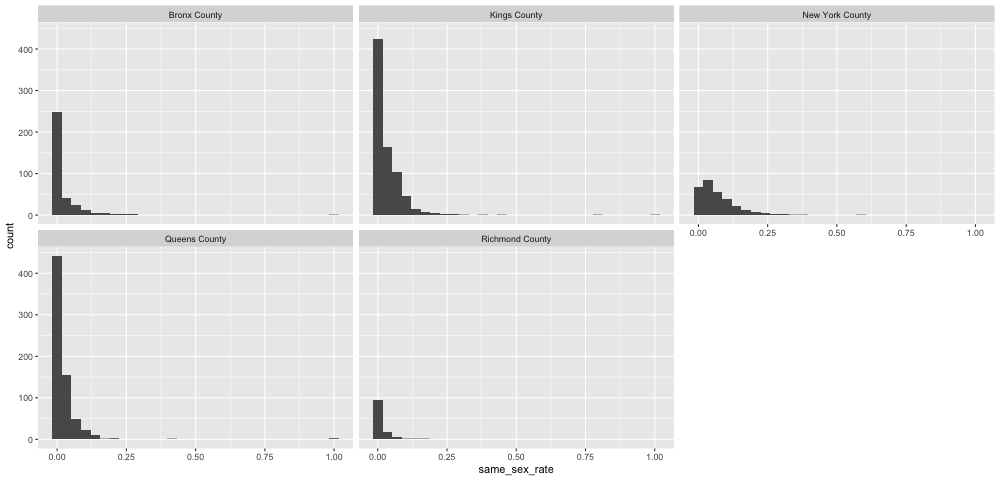

In [58]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=same_sex_rate) +
    geom_histogram() +
    facet_wrap(~borough)

# your code here. refer to example notebooks for help


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Removed 97 rows containing non-finite outside the scale range
(`stat_boxplot()`). 
  
R callback write-console: 2: Removed 97 rows containing missing values or values outside the scale range
(`geom_point()`). 
  


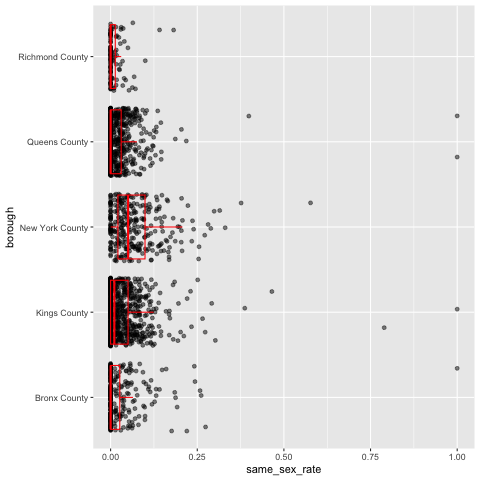

In [59]:
%%R

ggplot(nyc_census_data) + 
    aes(x=same_sex_rate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

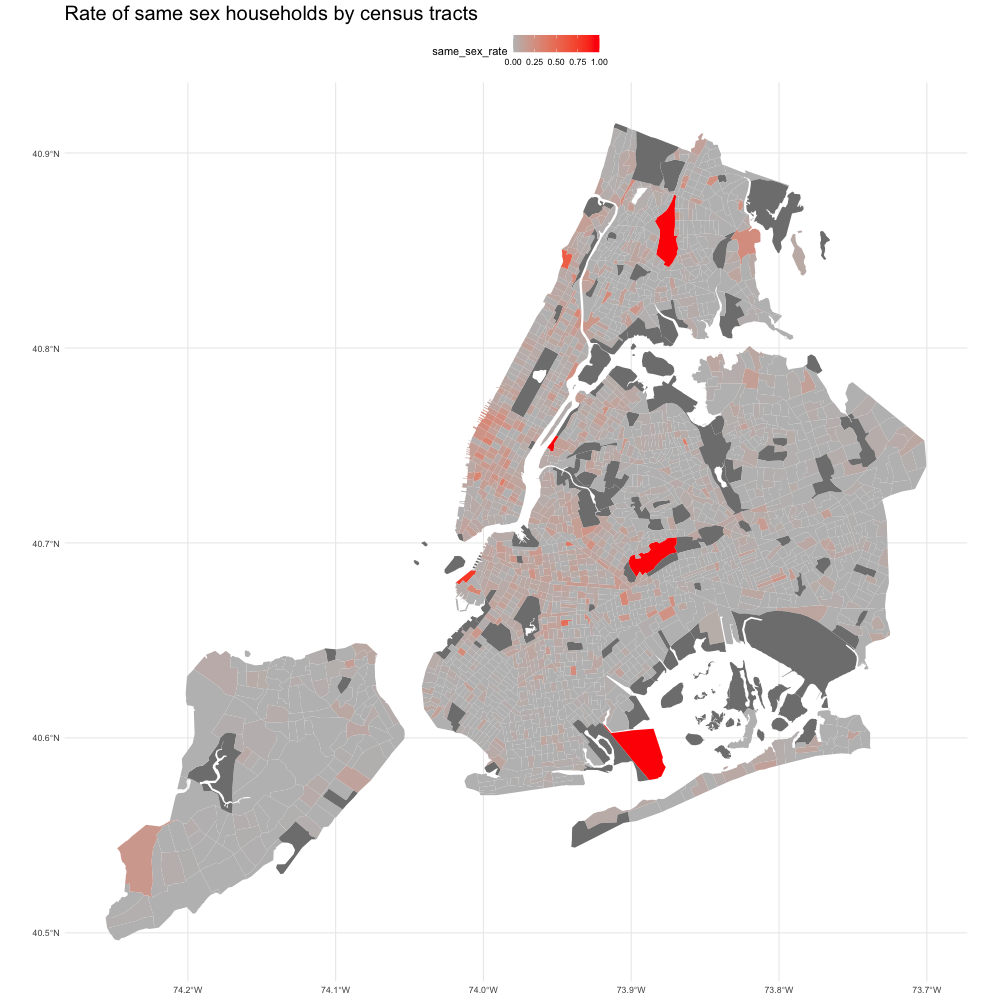

In [60]:
%%R -w 1000 -h 1000

# your code here. refer to example notebooks for help
nyc_census_data %>%
  ggplot(aes(fill = same_sex_rate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="gray", high="red") + 
  theme_minimal() +
  labs(
    title = "Rate of same sex households by census tracts"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )
